In [6]:
import pandas as pd
import numpy as np
import gc
np.random.seed(2019)

import warnings
warnings.filterwarnings('ignore')

from ml_metrics import rmsle
from sklearn.metrics import make_scorer, accuracy_score

from sklearn.model_selection import train_test_split, StratifiedKFold

import xgboost as xgb

from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

import xgbfir

from scikitplot.estimators import plot_learning_curve

import matplotlib.pyplot as plt

%matplotlib inline

from tqdm import tqdm

In [ ]:
train = pd.read_hdf('pml5/module3/input/diabetic_train.h5')
test = pd.read_hdf('pml5/module3/input/diabetic_test.h5')

In [ ]:
train = pd.read_hdf('../input/diabetic_train.h5')
test = pd.read_hdf('../input/diabetic_test.h5')

In [7]:
train = pd.read_hdf('diabetic_train.h5')
test = pd.read_hdf('diabetic_test.h5')

In [8]:
df_all = pd.concat([train, test])
del train, test
gc.collect()

44

# Feature Engineering

cechy do zwykłej faktoryzacji

In [9]:
factor = ['race', 'gender', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']

In [10]:
for cat_feat in factor:
    df_all['{0}_cat'.format(cat_feat)] = pd.factorize( df_all[cat_feat] )[0]

cechy do faktoryzacji posortowane - wszystkie modele były minimalnie lepsze w tej wersji

In [11]:
factor_to_sort = ['age', 'weight', 'max_glu_serum', 'A1Cresult']
age_idx = {'[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4, '[50-60)': 5, '[60-70)': 6, '[70-80)': 7,
           '[80-90)': 8, '[90-100)': 9}
weight_idx = {'?': 0, '[0-25)': 1, '[25-50)': 2, '[50-75)': 3, '[75-100)': 4, '[100-125)': 5, '[125-150)': 6, '[150-175)': 7,
              '[175-200)': 8}
max_glu_serum_idx = {'None': 0, 'Norm': 1, '>200': 2, '>300': 3}
A1Cresult_idx = {'None': 0, 'Norm': 1, '>7': 2, '>8': 3}

In [12]:
df_all['age_cat'] = df_all.age.map(lambda x: age_idx[x])
df_all['weight_cat'] = df_all.weight.map(lambda x: weight_idx[x])
df_all['max_glu_serum_cat'] = df_all.max_glu_serum.map(lambda x: max_glu_serum_idx[x])
df_all['A1Cresult_cat'] = df_all.A1Cresult.map(lambda x: A1Cresult_idx[x])

zliczanie rozpoznań (1-3) dla rekordu

In [13]:
df_all['diag_nr'] = df_all[ ['diag_1', 'diag_2', 'diag_3'] ]\
                             .apply(lambda x: int(x['diag_1']!='?') + int(x['diag_2']!='?') + int(x['diag_3']!='?'), axis=1)

zliczanie rekordów w bazie dla pacjenta - wersja wolniejsza (40s) i szybsza ze słownikiem (12s) 
- główna cecha, która dała 1.37 pierwszego dnia

In [ ]:
%time df_all['encounter_nr'] = df_all[ ['patient_nbr'] ]\
                             .apply(lambda x: df_all[ df_all['patient_nbr'] == x['patient_nbr']].shape[0], axis=1)

In [14]:
%time sum_encounter_nr = df_all.groupby('patient_nbr').agg(len)['encounter_id'].to_dict()
%time df_all['encounter_nr'] = df_all[ ['patient_nbr'] ].apply(lambda x: sum_encounter_nr[ x['patient_nbr'] ], axis=1)

Wall time: 11.6 s
Wall time: 719 ms


In [15]:
df_all['encounter_nr_log'] = (np.log(df_all[ df_all['encounter_nr']>0 ]['encounter_nr']+1))

sumowanie wszystkich interwencji, nagłych przypadków i wizyt ambulatoryjnych dla rekordu

In [16]:
df_all['intervention_nr'] = df_all[ ['number_outpatient', 'number_emergency', 'number_inpatient'] ]\
             .apply(lambda x: x['number_outpatient'] + x['number_emergency'] + x['number_inpatient'], axis=1)

In [17]:
df_all['emerg_nr'] = df_all[ ['number_emergency', 'number_inpatient'] ]\
             .apply(lambda x: x['number_emergency'] + x['number_inpatient'], axis=1)

In [18]:
df_all['ambulatory_nr'] = df_all[ ['number_outpatient', 'number_emergency'] ]\
             .apply(lambda x: x['number_outpatient'] + x['number_emergency'], axis=1)

Koncepcja: powtórne hospitalizacje są częstsze u pacjentów z powikłaniami cukrzycy, nadciśnieniem tętniczym, 
chorobą niedokrwienną serca, wszystkimi schorzeniami układu krążenia lub otyłoscią.

W Polsce do rozpoznań wykorzystywana jest klasyfikacja ICD10. ICD9 stosowana jest tylko do kodów procedur medycznych.
Używałem strony http://icd9.chrisendres.com/index.php?action=contents

In [ ]:
diag_list = set()
for col in ['diag_1', 'diag_2', 'diag_3']:
    for x in df_all[col]:
        diag_list.add(x)

diag_list

In [20]:
diag_dm_compl = {'250.02', '250.03', '250.1', '250.11', '250.12', '250.13', '250.2', '250.21', '250.22', '250.23', '250.3',
                 '250.31', '250.32', '250.33', '250.4', '250.41', '250.42', '250.43', '250.5', '250.51', '250.52', '250.53',
                 '250.6', '250.7', '250.8', '250.81', '250.82', '250.83', '250.9', '250.91', '250.92', '250.93', '362',
                 '365', '365.44', '366', '369', '353', '354', '357', '336', '337', '713', '707', '731', '785', '443', '581',
                 '583', '585'}

In [21]:
diag_ha = {'401', '402', '403', '404', '405'}

In [22]:
diag_ihd = {'410', '411', '412', '413', '414'}

In [23]:
diag_circul = {'391', '394', '395', '396', '397', '398', '401', '402', '403', '404', '405', '410', '411', '412',
 '413', '414', '415', '416', '417', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430',
 '431', '432', '433', '434', '435', '436', '437', '438', '440', '441', '442', '443', '444', '445', '446', '447',
 '448', '451', '452', '453', '454', '455', '456', '457', '458', '459'}

In [24]:
diag_obesity = {'278', 'V85', '783', '277', 'V45', '649'}

In [25]:
df_all['diag_complication_cat'] = df_all[ ['diag_1', 'diag_2', 'diag_3'] ].apply(lambda x:\
                    (x['diag_1'] in diag_dm_compl) | (x['diag_2'] in diag_dm_compl) | (x['diag_3'] in diag_dm_compl), axis=1)

In [26]:
df_all['diag_ha_cat'] = df_all[ ['diag_1', 'diag_2', 'diag_3'] ].apply(lambda x:\
                    (x['diag_1'] in diag_ha) | (x['diag_2'] in diag_ha) | (x['diag_3'] in diag_ha), axis=1)

In [27]:
df_all['diag_ihd_cat'] = df_all[ ['diag_1', 'diag_2', 'diag_3'] ].apply(lambda x:\
                    (x['diag_1'] in diag_ihd) | (x['diag_2'] in diag_ihd) | (x['diag_3'] in diag_ihd), axis=1)

In [28]:
df_all['diag_circul_cat'] = df_all[ ['diag_1', 'diag_2', 'diag_3'] ].apply(lambda x:\
                    (x['diag_1'] in diag_circul) | (x['diag_2'] in diag_circul) | (x['diag_3'] in diag_circul), axis=1)

In [29]:
df_all['diag_obesity_cat'] = df_all[ ['diag_1', 'diag_2', 'diag_3'] ].apply(lambda x:\
                    (x['diag_1'] in diag_obesity) | (x['diag_2'] in diag_obesity) | (x['diag_3'] in diag_obesity), axis=1)

Koncepcja przypisania do rozpoznania ilości (diag_high_number_80) lub częstości (diag_high_risk_80) readmicji. Wybrano 80 pierwszych rozpoznań z każdej kategorii.

ryzyko readmisji obliczane jako ilość rekordów '100' do wszystkich rekordów z daną wartością cechy (czasem też jako stosunek '100'/'0')

In [30]:
diag_list = {}
for col in ['diag_1', 'diag_2', 'diag_3']:
    for nr, x in enumerate(df_all[col]):
        if x not in diag_list:
            diag_list[x] = [0, 0, 0, 0.0]
        if df_all['readmitted'].iloc[nr] == 100:
            diag_list[x][0] += 1
        if df_all['readmitted'].iloc[nr] == 0:
            diag_list[x][1] += 1
        diag_list[x][2] += 1
        if (diag_list[x][1] + diag_list[x][0]) > 0:
            diag_list[x][3] = diag_list[x][0] / (diag_list[x][1] + diag_list[x][0])

#diag_high_risk_80 = [x[0] for x in sorted(diag_list.items(), key=lambda x: x[1][3], reverse=True)[0:80]]
#diag_high_number_80 = [x[0] for x in sorted(diag_list.items(), key=lambda x: x[1][0], reverse=True)[0:80]]
#print( [x for x in sorted(diag_list.items(), key=lambda x: x[1][3], reverse=True)[0:80]] )
#print( [x for x in sorted(diag_list.items(), key=lambda x: x[1][0], reverse=True)[0:80]] )

In [31]:
diag_high_number_80 = {'428', '276', '250', '427', '414', '401', '403', '599', '496', '585', '707', '491', '250.6', '584',
 '682', '486', '250.02', '780', '410', '996', '786', '434', '518', '425', '285', '411', '250.01', '38', '424', '715', '250.8',
 '440', '577', '493', '820', '998', '250.7', 'V45', '197', 'V58', '453', '560', '511', 'V57', '789', '571', '296', '578',
 '785', '272', '8', '250.13', '280', '530', '402', '997', '413', '305', '250.41', '198', '295', '250.82', '536', '162',
 '435', '733', '507', '574', '562', '433', '250.4', '535', '593', '70', '41', '438', '250.11', '787', '790'}

In [32]:
diag_high_risk_80 = {'643', '904', '968', '347', '526', '352', '964', '391', '500', '186', '96', '114', 'E945', '364',
 'E887', 'E876', 'E817', '597', '365.44', '838', 'E912', 'E946', '341', '146', '506', '980', '750', '250.31', '967',
 '619', '236', '48', '973', '580', '445', '208', '854', '11', '82', '684', '271', '890', '826', '334', '141', '258',
 '712', '908', '313', 'V49', '705', '250.53', '117', '250.42', '150', '913', '494', '452', '250.41', '200', '365',
 '693', '199', '581', '942', '934', '205', '586', 'V56', '215', '307', '374', '172', '945', '543', '179', '405', '318',
 '523', 'E924'}

In [33]:
df_all['diag_high_number_80_cat'] = df_all[ ['diag_1', 'diag_2', 'diag_3'] ].apply(lambda x:\
    (x['diag_1'] in diag_high_number_80) | (x['diag_2'] in diag_high_number_80) | (x['diag_3'] in diag_high_number_80), axis=1)

In [34]:
df_all['diag_high_risk_80_cat'] = df_all[ ['diag_1', 'diag_2', 'diag_3'] ].apply(lambda x:\
    (x['diag_1'] in diag_high_risk_80) | (x['diag_2'] in diag_high_risk_80) | (x['diag_3'] in diag_high_risk_80), axis=1)

In [35]:
diag_list = {}
for col in ['diag_1', 'diag_2', 'diag_3']:
    for nr, x in enumerate(df_all[col]):
        if x not in diag_list:
            diag_list[x] = [0, 0, 0, 0.0]
        if df_all['readmitted'].iloc[nr] == 100:
            diag_list[x][0] += 1
        if df_all['readmitted'].iloc[nr] == 0:
            diag_list[x][1] += 1
        diag_list[x][2] += 1
        if (diag_list[x][1] + diag_list[x][0]) > 0:
            diag_list[x][3] = diag_list[x][0] / (diag_list[x][1] + diag_list[x][0])

dgn_risk = {}
for x in diag_list.keys():
    if diag_list[x][1] > 0:
        dgn_risk[x] = diag_list[x][0]/diag_list[x][1]
    else:
        dgn_risk[x] = diag_list[x][0]
        
# [x for x in sorted(dgn_risk.items(), key=lambda x: x[1], reverse=True)[0:10]]

maksymalne ryzyko readmisji z pól rozpoznań 1-3, suma tych pól i suma wszystkich rekordów dla danego pacjenta

In [36]:
df_all['diag_risk_max'] = df_all[ ['diag_1', 'diag_2', 'diag_3'] ].apply(lambda x:\
                    max( dgn_risk[x['diag_1']], dgn_risk[x['diag_2']], dgn_risk[x['diag_3']] ), axis=1)

In [37]:
df_all['diag_risk_max_log'] = (np.log(df_all[ df_all['diag_risk_max']>0 ]['diag_risk_max']+1)+5)

In [38]:
df_all['diag_risk_sum'] = df_all[ ['diag_1', 'diag_2', 'diag_3'] ].apply(lambda x:\
                    dgn_risk[x['diag_1']] + dgn_risk[x['diag_2']] + dgn_risk[x['diag_3']], axis=1)

In [39]:
df_all['diag_risk_sum_log'] = (np.log(df_all[ df_all['diag_risk_sum']>0 ]['diag_risk_sum']+1)+4)

In [40]:
dict_sum_diag_risk_by_patient = df_all.groupby('patient_nbr').agg(np.sum)['diag_risk_sum'].to_dict()
df_all['total_diag_risk'] = df_all[ ['patient_nbr'] ].apply(lambda x: dict_sum_diag_risk_by_patient[ x['patient_nbr'] ], axis=1)

In [41]:
df_all['total_diag_risk_log'] = (np.log(df_all[ df_all['total_diag_risk']>0 ]['total_diag_risk']+1)+4)

In [42]:
discharge_dict = {}
for nr, x in enumerate(df_all['discharge_disposition_id']):
    if x not in discharge_dict:
        discharge_dict[x] = [0, 0, 0, 0]
    if df_all['readmitted'].iloc[nr] == 100:
        discharge_dict[x][0] += 1
        discharge_dict[x][2] += 1
    if df_all['readmitted'].iloc[nr] == 0:
        discharge_dict[x][1] += 1
        discharge_dict[x][2] += 1
    if df_all['readmitted'].iloc[nr] == '':
        discharge_dict[x][3] += 1
        
discharge_risk = {}
for x in discharge_dict.keys():
    if discharge_dict[x][1] > 0:
        discharge_risk[x] = discharge_dict[x][0]/discharge_dict[x][1]
    else:
        discharge_risk[x] = discharge_dict[x][0]

[x for x in sorted(discharge_risk.items(), key=lambda x: x[1], reverse=True)]

[(15, 2.7142857142857144),
 (12, 1),
 (9, 1.0),
 (28, 0.8),
 (22, 0.5845511482254697),
 (5, 0.41946308724832215),
 (2, 0.32014388489208634),
 (7, 0.3076923076923077),
 (3, 0.2982456140350877),
 (6, 0.28755510342488977),
 (4, 0.21524663677130046),
 (24, 0.21428571428571427),
 (18, 0.20717488789237667),
 (25, 0.18681318681318682),
 (1, 0.16918685856561608),
 (8, 0.13636363636363635),
 (23, 0.12280701754385964),
 (13, 0.0783132530120482),
 (14, 0.06432748538011696),
 (11, 0.0),
 (10, 0.0),
 (17, 0.0),
 (16, 0.0),
 (20, 0.0),
 (19, 0.0),
 (27, 0.0)]

zgony, flag 13 i 14 (hospicjum) wg mnie nie można tu zaliczyć

In [43]:
df_all['expired_cat'] = df_all[ ['discharge_disposition_id'] ].apply(lambda x:\
                    x['discharge_disposition_id'] in [11, 19, 20, 21], axis=1)   # 13, 14 ?

ryzyko readmisji związane z trybem wypisu i suma tego parametru dla wszystkich rekordów pacjenta

In [44]:
df_all['discharge_risk'] = df_all[ ['discharge_disposition_id'] ].apply(lambda x: \
                                                            discharge_risk[ x['discharge_disposition_id'] ], axis=1)
                                                                        

In [45]:
sum_discharge_risk = df_all.groupby('patient_nbr').agg(np.sum)['discharge_risk'].to_dict()
df_all['sum_discharge_risk'] = df_all[ ['patient_nbr'] ].apply(lambda x: sum_discharge_risk[ x['patient_nbr'] ], axis=1)
df_all['sum_discharge_risk_log'] = (np.log(df_all[ df_all['sum_discharge_risk']>0 ]['sum_discharge_risk']+1))

czy pacjent był zarówno w zbiorze treningowym jak i testowym - dodane do black_list

In [46]:
train = pd.read_hdf('diabetic_train.h5')
test = pd.read_hdf('diabetic_test.h5')
sum_train = train.groupby('patient_nbr').agg(len)['encounter_id'].to_dict()
sum_test = test.groupby('patient_nbr').agg(len)['encounter_id'].to_dict()
df_all['train_test_cat'] = df_all[ ['patient_nbr'] ].apply(lambda x:\
                    (x['patient_nbr'] in sum_train) & (x['patient_nbr'] in sum_test), axis=1)
del train, test, sum_train, sum_test
gc.collect()

98

suma wszystkich rekordów dla pacjenta z kolejnych pól 

In [47]:
sum_number_outpatient = df_all.groupby('patient_nbr').agg(np.sum)['number_outpatient'].to_dict()
df_all['sum_number_outpatient'] = df_all[ ['patient_nbr'] ].apply(lambda x: sum_number_outpatient[ x['patient_nbr'] ], axis=1)

In [48]:
sum_number_emergency = df_all.groupby('patient_nbr').agg(np.sum)['number_emergency'].to_dict()
df_all['sum_number_emergency'] = df_all[ ['patient_nbr'] ].apply(lambda x: sum_number_emergency[ x['patient_nbr'] ], axis=1)

In [49]:
sum_number_inpatient = df_all.groupby('patient_nbr').agg(np.sum)['number_inpatient'].to_dict()
df_all['sum_number_inpatient'] = df_all[ ['patient_nbr'] ].apply(lambda x: sum_number_inpatient[ x['patient_nbr'] ], axis=1)

In [50]:
sum_num_procedures = df_all.groupby('patient_nbr').agg(np.sum)['num_procedures'].to_dict()
df_all['sum_num_procedures'] = df_all[ ['patient_nbr'] ].apply(lambda x: sum_num_procedures[ x['patient_nbr'] ], axis=1)

In [51]:
sum_num_lab_procedures = df_all.groupby('patient_nbr').agg(np.sum)['num_lab_procedures'].to_dict()
df_all['sum_num_lab_procedures'] = df_all[ ['patient_nbr'] ].apply(lambda x: sum_num_lab_procedures[ x['patient_nbr'] ], axis=1)

In [52]:
sum_time_in_hospital = df_all.groupby('patient_nbr').agg(np.sum)['time_in_hospital'].to_dict()
df_all['sum_time_in_hospital'] = df_all[ ['patient_nbr'] ].apply(lambda x: sum_time_in_hospital[ x['patient_nbr'] ], axis=1)

ilość różnych leków stosowanych u pacjenta przy danej wizycie (rekordzie)

In [53]:
if 'drug_multi_nr' in df_all:
    del df_all['drug_multi_nr']
df_all['drug_multi_nr'] = df_all[ ['metformin'] ].apply(lambda x: 1 if x['metformin'] > 0 else 0, axis=1)

drugs = ['repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin']

for col in drugs:
    df_all['drug_multi_nr'] = df_all[ [col, 'drug_multi_nr'] ]\
         .apply(lambda x: x['drug_multi_nr']+1 if x[col] > 0 else x['drug_multi_nr'], axis=1)
    
def multi_add(x):
    if x <= 1: return 2
    else: return x

drugs = ['glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

for col in drugs:
    df_all['drug_multi_nr'] = df_all[ [col, 'drug_multi_nr'] ]\
        .apply(lambda x: multi_add(x['drug_multi_nr']) if x[col] > 0 else x['drug_multi_nr'], axis=1)

czy pacjent miał 1 lek czy kilka leków

In [54]:
df_all['drug_multi_cat'] = df_all[ ['drug_multi_nr'] ].apply(lambda x: x['drug_multi_nr'] > 1, axis=1)

łączne ryzyko readmicji dla wszystkich stosowanych leków - suma dla rekordu

In [55]:
drug_dict = {}
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
         'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
         'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
         'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
for col in drugs:
    for nr, x in enumerate(df_all[col]):
        if col not in drug_dict:
            drug_dict[col] = [0, 0, 0, 0]
        if df_all[col].iloc[nr] > 0:
            if df_all['readmitted'].iloc[nr] == 100:
                drug_dict[col][0] += 1
                drug_dict[col][2] += 1
            if df_all['readmitted'].iloc[nr] == 0:
                drug_dict[col][1] += 1
                drug_dict[col][2] += 1
            if df_all['readmitted'].iloc[nr] == '':
                drug_dict[col][3] += 1

drug_risk = {}
for x in drug_dict.keys():
    if drug_dict[x][1] > 0:
        drug_risk[x] = drug_dict[x][0] / drug_dict[x][1]        # sprawdzić sumę w mianowniku
    else:
        drug_risk[x] = drug_dict[x][0]

# [x for x in sorted(discharge_risk.items(), key=lambda x: x[1], reverse=True)]                
                
# [x for x in sorted(drug_risk.items(), key=lambda x: x[1], reverse=True)[0:80]]

df_all['sum_drug_risk'] = 0.0

def sum_drug_risk(x):
    result = 0.0
    for col in drugs:
        if x[col] > 0:
            result += drug_risk[col]
    return result

%time df_all['sum_drug_risk'] = df_all[ drugs ].apply(lambda x: sum_drug_risk(x), axis=1)

Wall time: 12.8 s


łączne ryzyko readmicji dla wszystkich stosowanych leków - suma dla pacjenta

In [56]:
sum_drug_risk = df_all.groupby('patient_nbr').agg(np.sum)['sum_drug_risk'].to_dict()
df_all['total_drug_risk'] = df_all[ ['patient_nbr'] ].apply(lambda x: sum_drug_risk[ x['patient_nbr'] ], axis=1)
df_all['total_drug_risk_log'] = (np.log(df_all[ df_all['total_drug_risk']>0 ]['total_drug_risk']+1)+3)

w danej wizycie nie przepisano leku

In [57]:
df_all['drug_none_cat'] = df_all[ ['drug_multi_nr'] ].apply(lambda x: x['drug_multi_nr'] == 0, axis=1)

stosowano insulinę

In [58]:
df_all['drug_insulin_cat'] = df_all[ ['insulin'] ].apply(lambda x: x['insulin'] > 0, axis=1)

kolumna używana w procedurze run_two_models - najpierw regresja, później klasyfikacja

In [59]:
df_all['model1_cat'] = 0

zmieniono leki na wizycie

In [60]:
if 'drug_change_cat' in df_all:
    del df_all['drug_change_cat']
df_all['drug_change_cat'] = df_all[ ['metformin'] ].apply(lambda x: x['metformin'] > 1, axis=1)

drugs = ['repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

for col in tqdm(drugs):
    df_all['drug_change_cat'] = df_all[ [col, 'drug_change_cat'] ]\
        .apply(lambda x: (x[col] > 1) | x['drug_change_cat'], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:22<00:00,  1.01s/it]


zwiększono dawki leków

In [61]:
if 'drug_up_cat' in df_all:
    del df_all['drug_up_cat']
df_all['drug_up_cat'] = df_all[ ['metformin'] ].apply(lambda x: x['metformin'] == 2, axis=1)

drugs = ['repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

for col in tqdm(drugs):
    df_all['drug_up_cat'] = df_all[ [col, 'drug_up_cat'] ]\
        .apply(lambda x: (x[col] == 2) | x['drug_up_cat'], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:23<00:00,  1.01s/it]


zmniejszono dawki leków

In [62]:
if 'drug_down_cat' in df_all:
    del df_all['drug_down_cat']
df_all['drug_down_cat'] = df_all[ ['metformin'] ].apply(lambda x: x['metformin'] == 3, axis=1)

drugs = ['repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

for col in tqdm(drugs):
    df_all['drug_down_cat'] = df_all[ [col, 'drug_down_cat'] ]\
        .apply(lambda x: (x[col] == 3) | x['drug_down_cat'], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:22<00:00,  1.02s/it]


liczenie sum dla pacjenta, logarytmów dla sum i logarytmów dla zwykłych zmiennych "ciągłych"

In [63]:
for col in tqdm(['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 
            'number_emergency', 'number_inpatient', 'number_diagnoses', 'intervention_nr', 'emerg_nr', 'ambulatory_nr',
           'drug_multi_nr', 'diag_nr']):
    sum_dict = df_all.groupby('patient_nbr').agg(np.sum)[col].to_dict()
    col_name = 'sum_{0}'.format(col)
    df_all[col_name] = df_all[ ['patient_nbr'] ]\
            .apply(lambda x: sum_dict[ x['patient_nbr'] ], axis=1)
    df_all[col_name+'_log'] = (np.log( df_all[ df_all[col_name]>0 ][col_name]+1 ))
    df_all[col+'_log'] = (np.log( df_all[ df_all[col]>0 ][col]+1 ))

del sum_dict, col_name
gc.collect()

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.37s/it]


119

sprawdzanie i wypełnianie zerem wartoiści NaN - występowały tylko dla logarytmów

In [64]:
print(df_all[ [feat for feat in  df_all.columns if feat.endswith('_log') ] ].isnull().any().any()) # NaN tylko w kolumnach z log
print(df_all[ [feat for feat in  df_all.columns if not feat.endswith('_log') ] ].isnull().any().any()) # brak NaN w innych

print(df_all.isnull().any().any())
df_all.fillna(0, inplace=True)
print(df_all.isnull().any().any())

True
False
True
False


ewentualne czyszczenie pamięci ze zbędnych słowników

In [ ]:
#del [obj for obj in list(globals().keys()) if (type(eval(obj)) == dict) & (not obj.startswith("_"))][1:]
gc.collect()

In [65]:
[obj for obj in list(globals().keys()) if (type(eval(obj)) == dict) & (not obj.startswith("_"))][1:]

['age_idx',
 'weight_idx',
 'max_glu_serum_idx',
 'A1Cresult_idx',
 'sum_encounter_nr',
 'diag_list',
 'dgn_risk',
 'dict_sum_diag_risk_by_patient',
 'discharge_dict',
 'discharge_risk',
 'sum_discharge_risk',
 'sum_number_outpatient',
 'sum_number_emergency',
 'sum_number_inpatient',
 'sum_num_procedures',
 'sum_num_lab_procedures',
 'sum_time_in_hospital',
 'drug_dict',
 'drug_risk',
 'sum_drug_risk']

### uruchomienie modelu z parametrami i zestawem cech
cv - przyjmuje walidację, plot=True rysuje krzywą uczenia, csv - nazwa pliku do wysyłki, 
cut - punkt odcięcia dla regresji ('0'/'100'), dla 0 regresja zwraca wartości >= 0 nie zaokrąglając do 100,
plot nie działa dla regresji, granice dla rmsle określa linijka z [-1.5, -0.6], nie zwracamy uwagi na minus

funkcja zwraca ilość '100' i '0' dla test i train, rmsle i wyszkolony model

In [66]:
def run_model(feats, model, params, cv=None, plot=None, csv=None, cut=0):
    
    train = df_all[df_all.readmitted != '']
    test = df_all[df_all.readmitted == '']

    X = train[feats].values
    y = (train['readmitted'].values).astype(np.float64)

    model = model(**params)

    if cv:   
        scores = []
        for train_idx, test_idx in cv.split(X, y):
            X_fold_train, X_fold_test = X[train_idx], X[test_idx]
            y_fold_train, y_fold_test = y[train_idx], y[test_idx]
            model.fit(X_fold_train, y_fold_train)
            y_pred = (model.predict(X_fold_test))
            y_pred[ y_pred<0 ] = 0
            score = rmsle(y_fold_test, y_pred)
            scores.append( score )
    else:
        model.fit(X, y)
        
    X_test = test[feats].values
    test['readmitted'] = model.predict(X_test)
    y_pred = (model.predict(X)).astype(np.float64)
    if cut == 0: 
        test['readmitted'] = test['readmitted'].map(lambda x: 0 if x < 0 else x)
        y_pred[ y_pred <  0 ] = 0
    else:
        test['readmitted'] = test['readmitted'].map(lambda x: 0 if x < cut else 100)
        y_pred[ y_pred <  cut ] = 0
        y_pred[ y_pred >= cut ] = 100
    score = rmsle(y, y_pred)
    
    if csv:
        test[ ['id', 'readmitted'] ].to_csv(csv, index=False)
    
    if plot:
        ax = plt.gca()
        ax.set_ylim([-1.5, -0.6])
        rmsle_score = make_scorer(rmsle, greater_is_better=False)
        plot_learning_curve(model, X, y, random_state=2019, shuffle=True, n_jobs=8, scoring=rmsle_score, ax=ax);
    
    return(('test', test[test['readmitted']==100].shape[0], test[test['readmitted']==0].shape[0]),
           ('train', train[train['readmitted']==100].shape[0], train[train['readmitted']==0].shape[0]),
           ('score', score), model)

### uruchamia kolejno dwa modele, pierwszy przekazuje drugiemu predykcję przez cechę 'model1_cat'

In [67]:
def run_two_models(feats_1, model_1, params_1,
                   feats_2, model_2, params_2,
                   cv=None, plot=None, csv=None, cut=50):
    
    train = df_all[df_all.readmitted != '']
    test = df_all[df_all.readmitted == '']

    X = train[feats_1].values
    y = (train['readmitted'].values).astype(np.float64)

    model_1 = model_1(**params_1)

    if cv:   
        scores = []
        for train_idx, test_idx in cv.split(X, y):
            X_fold_train, X_fold_test = X[train_idx], X[test_idx]
            y_fold_train, y_fold_test = y[train_idx], y[test_idx]
            model_1.fit(X_fold_train, y_fold_train)
            y_pred = (model_1.predict(X_fold_test))
            y_pred[ y_pred<0 ] = 0
            score = rmsle(y_fold_test, y_pred)
            scores.append( score )
    else:
        model_1.fit(X, y)
    
    X_all = df_all[feats_1].values
    df_all['model1_cat'] = model_1.predict(X_all)
    df_all['model1_cat'] = df_all['model1_cat'].map(lambda x: 0 if x < cut else 100)
    
    train = df_all[df_all.readmitted != '']
    test = df_all[df_all.readmitted == '']

    X = train[feats_2].values
    y = (train['readmitted'].values).astype(np.float64)
    
    model_2 = model_2(**params_2)

    if cv:   
        scores = []
        for train_idx, test_idx in cv.split(X, y):
            X_fold_train, X_fold_test = X[train_idx], X[test_idx]
            y_fold_train, y_fold_test = y[train_idx], y[test_idx]
            model_2.fit(X_fold_train, y_fold_train)
            y_pred = (model_2.predict(X_fold_test))
            y_pred[ y_pred<0 ] = 0
            score = rmsle(y_fold_test, y_pred)
            scores.append( score )
    else:
        model_2.fit(X, y)
      
    X_test = test[feats_2].values
    test['readmitted'] = model_2.predict(X_test)
    test['readmitted'] = test['readmitted'].map(lambda x: 0 if x < cut else 100)
    y_pred = (model_2.predict(X)).astype(np.float64)
    y_pred[ y_pred <  cut ] = 0
    y_pred[ y_pred >= cut ] = 100
    score = rmsle(y, y_pred), accuracy_score(y, y_pred)
    if csv:
        test[ ['id', 'readmitted'] ].to_csv(csv, index=False)
    
    if plot:
        #ax = plt.gca()
        #ax.set_ylim([-1.1, -0.6])
        rmsle_score = make_scorer(rmsle, greater_is_better=False)
        plot_learning_curve(model_2, X, y, random_state=2019, shuffle=True, n_jobs=8); # scoring=rmsle_score, ax=ax
    
    df_all['model1_cat'] = 0
    
    return(('test', test[test['readmitted']==100].shape[0], test[test['readmitted']==0].shape[0]),
           ('train', train[train['readmitted']==100].shape[0], train[train['readmitted']==0].shape[0]),
           ('score', score), model_2)

### optymalizacja parametrów modelu

In [68]:
def space_to_param(space):
    int_param = ['max_depth', 'random_state', 'min_child_weight', 'n_estimators', 'n_jobs']
    par = {}
    cut = 50
    cv  = None
    model = None
    feats = None
    for x in space:
        if x == 'cut':     cut    = int(space[x])
        if x == 'cv':      cv     = space[x]
        if x == 'model':   model  = space[x]
        if x == 'feats':   feats  = list(space[x])    
        if x in int_param: par[x] = int(space[x])
        else:              par[x] = space[x]            
    return (par, cut, cv, model, feats)

def param_opt(space):
    params = space_to_param(space)
    with_params = {
        'feats' : params[4],
        'model' : params[3],
        'params': params[0],
        'cv'    : params[2],
        'plot'  : None,
        'csv'   : None,
        'cut'   : params[1]
    }
    result = run_model(**with_params)
    return{'loss':result[2][1], 'status': STATUS_OK }

### permutation importance

In [69]:
def perm_model(feats, model, params, cv=None, plot=None, csv=None, cut=50):
    
    train = df_all[df_all.readmitted != '']
    test = df_all[df_all.readmitted == '']
    
    train = train.fillna(-1)

    X = train[feats].values
    y = (train['readmitted'].values).astype(np.float64)

    model = model(**params)
    
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X, y, shuffle=True, random_state=0)

    if cv:   
        scores = []
        for train_idx, test_idx in cv.split(X_sub_train, y_sub_train):
            X_fold_train, X_fold_test = X_sub_train[train_idx], X_sub_train[test_idx]
            y_fold_train, y_fold_test = y_sub_train[train_idx], y_sub_train[test_idx]
            model.fit(X_fold_train, y_fold_train)
            y_pred = (model.predict(X_fold_test))
            y_pred[ y_pred<0 ] = 0
            score = rmsle(y_fold_test, y_pred)
            scores.append( score )
    else:
        model.fit(X_sub_train, y_sub_train)
        
    perm = PermutationImportance(model).fit(X_sub_test, y_sub_test)
    return perm

# Feature Selection

Tu miałem największy problem. Zawsze najlepszy wynik dawało uwzględnienie wszystkich cech jakie na danym etapie miałem, z niemal podstawowymi ustawieniami modelu.

Poczatkowo lepsza była klasyfikacja, później regresja. W tej ostatniej ważniejszy był punkt odcięcia niż rmsle i accuracy na zbiorze treningowym.

Optymalizacja parametrów zawsze dawała gorsze efekty (overfit).

### grupy cech

In [70]:
black_list_feats = ['id', 'encounter_id', 'readmitted', 'train_test_cat']

all_feats = df_all.select_dtypes(include=[np.number, bool]).columns.values
all_feats = [feat for feat in all_feats if feat not in (black_list_feats)]

used_drug_feats = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 
               'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 
               'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
               'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

cat_feats = [feat for feat in  all_feats if feat.endswith('_cat') ]\
          + [feat for feat in  all_feats if feat.endswith('_id') ]\
          + used_drug_feats + ['patient_nbr', 'change', 'diabetesMed', 'id']

multi_cat_feats = ['race_cat', 'payer_code_cat', 'medical_specialty_cat', 'diag_1_cat', 'diag_2_cat', 'diag_3_cat', 
                   'age_cat', 'weight_cat', 'max_glu_serum_cat', 'A1Cresult_cat', 'admission_type_id', 
                   'discharge_disposition_id', 'admission_source_id', 'patient_nbr', 'id', 'encounter_id']

binary_cat_feats = [feat for feat in cat_feats if feat not in (multi_cat_feats + used_drug_feats)]

continuous_feats = [feat for feat in all_feats if feat not in cat_feats]

log_feats = [feat for feat in  all_feats if feat.endswith('_log') ]

good_log_feats = ['diag_risk_max_log', 'diag_risk_sum_log', 'total_diag_risk_log', 'sum_num_lab_procedures_log', 
                  'num_lab_procedures_log', 'num_medications_log', 'sum_num_medications_log', 
                  'total_drug_risk_log', 'sum_time_in_hospital_log', 'time_in_hospital_log', 'sum_number_diagnoses_log']

sum_feats = [feat for feat in  all_feats if feat.startswith('sum_') ]\
          + [feat for feat in  all_feats if feat.startswith('total_') ] + ['encounter_nr']

risk_feats = [feat for feat in  all_feats if ~feat.find('risk') ]
risk_feats.remove('diag_high_risk_80_cat')

drug_feats = [feat for feat in  all_feats if ~feat.find('drug') ]

diag_feats = [feat for feat in  all_feats if ~feat.find('diag') ]

In [ ]:
df_all.select_dtypes(include=[np.number, bool]).columns.values
[feat for feat in  df_all.columns if feat.endswith('_cat') ]
[feat for feat in  df_all.columns if feat.startswith('sum_') ]
[feat for feat in  df_all.columns if feat.endswith('_log') ]
[feat for feat in  df_all.columns if feat.endswith('_cat') ]
[feat for feat in  df_all.columns if ~feat.find('diag') ]
[feat for feat in  df_all.columns if ~feat.find('drug') ]
[feat for feat in  df_all.columns if ~feat.find('sum') ]
[feat for feat in  df_all.columns if feat.startswith('total_') ]

przykładowe wyniki klasyfikacji dla różnych grup cech

all clas skfold colsample
(('test', 4037, 29133), ('train', 5721, 27330), ('score', (1.1874474609521182, 0.9337992799007594)))
all clas skfold
(('test', 4073, 29097), ('train', 5721, 27330), ('score', (1.185002753532511, 0.9340715863362682)))
best_clas_skfold clas skfold
(('test', 4052, 29118), ('train', 5721, 27330), ('score', (1.1904286186895825, 0.9334664609240265)))
best_clas_skfold clas skfold colsample
(('test', 3992, 29178), ('train', 5721, 27330), ('score', (1.191240366904396, 0.9333756921121903)))
log_feats clas skfold
(('test', 3936, 29234), ('train', 5721, 27330), ('score', (1.1998648441584605, 0.9324074914526036)))
log_feats clas skfold colsample
(('test', 3919, 29251), ('train', 5721, 27330), ('score', (1.2038862994419666, 0.9319536473934222)))
continuous_feats clas skfold
(('test', 3984, 29186), ('train', 5721, 27330), ('score', (1.2049564208083143, 0.931832622310974)))
continuous_feats clas skfold colsample
(('test', 4001, 29169), ('train', 5721, 27330), ('score', (1.2014750414977722, 0.932225953828931)))
eli5_best_clas
(('test', 4098, 29072), ('train', 5721, 27330), ('score', 1.2062927375335026))

pracowałem na własnym komputerze w jupyter - dla mnie była to bardziej stabilna wersja

dlatego wszędzie w parametrach jest 'n_jobs': 8

### kolejne dodawanie najlepszej cechy ze wszystkich zadanych

In [71]:
# features search by adding

added_feats = all_feats

with_params = {
    'feats' : [],
    'model' : xgb.XGBRegressor,
    'params': {'n_jobs': 8,
               'random_state': 2019,
               'objective': 'reg:squarederror',
               'max_depth': 5,
               'subsample': 0.95},
    'cv'    : StratifiedKFold(n_splits=4, random_state=2019),
    'plot'  : None,
    'csv'   : None,
    'cut'   : 50
}

best = 100;
best_feat = ''

exclude = []

for x in range(0,1):
    for feat in tqdm(added_feats):
        if feat in exclude: continue
        if feat not in with_params['feats']:
            with_params['feats'].append(feat)
            result = run_model(**with_params)
            if result[2][1] < best:
                best = result[2][1]
                best_feat = feat
            with_params['feats'].remove(feat)
    if best_feat != '':
        print(best_feat, best)
        with_params['feats'].append(best_feat)
        best_feat = ''
    else:
        break


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [02:17<00:00,  1.14s/it]


total_diag_risk_log 2.1580966137641444


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [03:54<00:00,  1.98s/it]


number_inpatient 2.088092848496852


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [04:07<00:00,  2.09s/it]


sum_number_inpatient 1.9538224944036235


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [04:00<00:00,  2.00s/it]


sum_discharge_risk 1.9162263329909643


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [04:13<00:00,  2.14s/it]


payer_code_cat 1.8782406947609276


In [72]:
# features search by adding

added_feats = log_feats

with_params = {
    'feats' : [],
    'model' : xgb.XGBClassifier,
    'params': {'n_jobs': 8,
               'random_state': 2019,
               'max_depth': 5,
               'subsample': 0.95,
},
    'cv'    : StratifiedKFold(n_splits=4, random_state=2019),
    'plot'  : None,
    'csv'   : None,
    'cut'   : 50
}

best = 100;
best_feat = ''

exclude = []

for x in range(0,1):
    for feat in tqdm(added_feats):
        if feat in exclude: continue
        if feat not in with_params['feats']:
            with_params['feats'].append(feat)
            result = run_model(**with_params)
            if result[2][1] < best:
                best = result[2][1]
                best_feat = feat
            with_params['feats'].remove(feat)
    if best_feat != '':
        print(best_feat, best)
        with_params['feats'].append(best_feat)
        best_feat = ''
    else:
        break


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:49<00:00,  1.34s/it]


sum_discharge_risk_log 1.6322097978584305


### kasowanie najgorszej i najlepszej cechy z modelu

In [74]:
# liczy się długo

# features search by deleting
with_params = {
    'feats' : binary_cat_feats,
    'model' : xgb.XGBClassifier,
    'params': {'n_jobs': 8,
               'random_state': 2019,
               'objective': 'reg:squarederror',
               'max_depth': 5,
               'subsample': 0.95},

    'cv'    : StratifiedKFold(n_splits=4, random_state=2019),
    'plot'  : None,
    'csv'   : None,
    'cut'   : 47
}

worst = 0
worst_feat = ''
best = 100
best_feat = ''

worst_list = []
best_list = []

for x in range(0,1): # 50
    for feat in tqdm(with_params['feats']):
        with_params['feats'].remove(feat)
        result = run_model(**with_params)
        if result[2][1] < best:
            best = result[2][1]
            worst_feat = feat            
        with_params['feats'].append(feat)
        if result[2][1] > worst:
            worst = result[2][1]
            best_feat = feat
    
    print([worst_feat], [best], [best_feat], [worst])
    worst_list.append(worst_feat)
    best_list.append(best_feat)
    if worst_feat in with_params['feats']: with_params['feats'].remove(worst_feat)
    if best_feat in with_params['feats']: with_params['feats'].remove(best_feat)
    worst = 0
    worst_feat = ''
    best = 100
    best_feat = ''
    
print('worst', worst_list)
print('best', best_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:45<00:00,  2.81s/it]


['drug_change_cat'] [1.9130515756512216] ['diag_high_risk_80_cat'] [1.9192734448705837]
worst ['drug_change_cat']
best ['diag_high_risk_80_cat']


In [76]:
# liczy się długo

with_params = {
    'feats' : multi_cat_feats,
    'model' : xgb.XGBRegressor,
    'params': {'n_jobs': 8,
               'random_state': 2019,
               'objective': 'reg:squarederror',
               'max_depth': 5,
               'subsample': 0.95},
    'cv'    : StratifiedKFold(n_splits=4, random_state=2019),
    'plot'  : None,
    'csv'   : None,
    'cut'   : 47
}

worst = 0
worst_feat = ''
best = 100
best_feat = ''

worst_list = []
best_list = []

for x in range(0,1): # 50
    for feat in tqdm(with_params['feats'], leave=False):
        with_params['feats'].remove(feat)
        result = run_model(**with_params)
        if result[2][1] < best:
            best = result[2][1]
            worst_feat = feat            
        with_params['feats'].append(feat)
        if result[2][1] > worst:
            worst = result[2][1]
            best_feat = feat
    
    print([worst_feat], [best], [best_feat], [worst])
    worst_list.append(worst_feat)
    best_list.append(best_feat)
    if worst_feat in with_params['feats']: with_params['feats'].remove(worst_feat)
    if best_feat in with_params['feats']: with_params['feats'].remove(best_feat)
    worst = 0
    worst_feat = ''
    best = 100
    best_feat = ''
    
print('worst', worst_list)
print('best', best_list)

['diag_1_cat'] [1.8783771915893168] ['discharge_disposition_id'] [1.9039345186349308]
worst ['diag_1_cat']
best ['discharge_disposition_id']


### szukanie najlepszych cech przez eli5 - oddzielnie dla każdej grupy cech

In [77]:
perm_feats = continuous_feats
perm_feats = [feat for feat in perm_feats if feat not in black_list_feats]
with_params = {
    'feats' : perm_feats,
    'model' : xgb.XGBRegressor,
    'params': {'n_jobs': 8,
               'random_state': 2019,
               'objective': 'reg:squarederror',
               'max_depth': 5,
               'subsample': 0.95},
    'cv'    : StratifiedKFold(n_splits=4, random_state=2019),
    'plot'  : None,
    'csv'   : None,
    'cut'   : 50
    
}

perm = perm_model(**with_params)
eli5.show_weights(perm, feature_names=perm_feats, top=150)

Weight,Feature
0.3791 ± 0.0095,encounter_nr
0.2972 ± 0.0133,number_inpatient
0.1900 ± 0.0097,sum_number_inpatient
0.0339 ± 0.0040,sum_intervention_nr
0.0261 ± 0.0039,discharge_risk
0.0229 ± 0.0016,sum_emerg_nr
0.0193 ± 0.0013,total_diag_risk
0.0125 ± 0.0016,intervention_nr
0.0109 ± 0.0021,emerg_nr
0.0107 ± 0.0041,diag_risk_sum


In [78]:
perm_feats = binary_cat_feats
perm_feats = [feat for feat in perm_feats if feat not in black_list_feats]
with_params = {
    'feats' : perm_feats,
    'model' : xgb.XGBClassifier,
    'params': {'n_jobs': 8,
               'random_state': 2019,
               'max_depth': 5,
               'subsample': 0.95},
    'cv'    : StratifiedKFold(n_splits=4, random_state=2019),
    'plot'  : True,
    'csv'   : None,
    'cut'   : 0
    
}

perm = perm_model(**with_params)
eli5.show_weights(perm, feature_names=perm_feats, top=150)

Weight,Feature
0.0006 ± 0.0005,drug_down_cat
0.0004 ± 0.0002,drug_multi_cat
0.0003 ± 0.0002,diag_circul_cat
0.0002 ± 0.0001,diag_ha_cat
0.0002 ± 0.0003,diag_obesity_cat
0.0002 ± 0.0002,diag_complication_cat
0.0001 ± 0.0001,drug_insulin_cat
0.0001 ± 0.0001,drug_none_cat
0.0001 ± 0.0002,diag_ihd_cat
0.0000 ± 0.0002,drug_up_cat


### szukanie najlepszych cech przez xgbfir

In [102]:
model_feats = all_feats
model_feats = [feat for feat in model_feats if feat not in black_list_feats]
with_params = {
    'feats' : model_feats,
    'model' : xgb.XGBRegressor,
    'params': {'n_jobs': 8,
               'random_state': 2019,
               'objective': 'reg:squarederror',
               'max_depth': 5,
               'learning_rate': 0.1966318758378431, 
               'n_estimators': 960, 
               'subsample': 0.7092775404962167},
    'cv'    : StratifiedKFold(n_splits=4, random_state=2019),
    'plot'  : None,
    'csv'   : 'model37_xgbfir_best_reg.csv',
    'cut'   : 50
}
result = None
for x in range(55, 56):
    with_params['cut'] = x
    result = run_model(**with_params)
    print(result[:3], x)
xgbfir.saveXgbFI(result[3], feature_names=model_feats, OutputXlsxFile='diabetes.xlsx')

(('test', 4195, 28975), ('train', 5721, 27330), ('score', 0.7461868918923346)) 55


Wall time: 28.2 s
(('test', 4108, 29062), ('train', 5721, 27330), ('score', 1.1963686486791172))


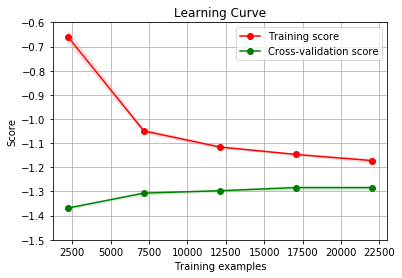

In [101]:
model_feats = all_feats
model_feats = [feat for feat in model_feats if feat not in black_list_feats]
with_params = {
    'feats' : model_feats,
    'model' : xgb.XGBClassifier,
    'params': {'n_jobs': 8,
               'random_state': 2019,
               'max_depth': 5,
               'subsample': 0.95,
},
    'cv'    : StratifiedKFold(n_splits=4, random_state=2019),
    'plot'  : True,
    'csv'   : None,
    'cut'   : 50
}

%time result = run_model(**with_params)
print(result[:3])
xgbfir.saveXgbFI(result[3], feature_names=model_feats, OutputXlsxFile='diabetes.xlsx')

### optymalizacja parametrów modelu

In [92]:
space ={
    'subsample': hp.uniform('x_subsample', 0.7, 1.),
    'learning_rate': hp.uniform('x_learning_rate', 0.05, 0.2),
    'max_depth': 5, 
    'random_state': hp.quniform('x_random_state', 1, 1000, 1), 
    'n_estimators': 100,
    'objective': 'reg:squarederror',
    'n_jobs': 8,
    'cut': 55, # hp.quniform('x_cut', 42, 53, 1),
    'cv': StratifiedKFold(n_splits=4, random_state=2019),
    'model': xgb.XGBRegressor,
    'feats': sum_feats
}

trials = Trials()
best_params = fmin(fn=param_opt,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best_params)

100%|███████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.07s/it, best loss: 1.4760916712197933]
The best params:  {'x_learning_rate': 0.1998182705297261, 'x_random_state': 56.0, 'x_subsample': 0.990058617557935}


In [93]:
space ={
    'subsample': hp.uniform('x_subsample', 0.7, 1.),
    'learning_rate': hp.uniform('x_learning_rate', 0.05, 0.2),
    'max_depth': 5, 
    'random_state': hp.quniform('x_random_state', 1, 1000, 1), 
    'n_estimators': 100,
    'n_jobs': 8,
    'cut': 55, # hp.quniform('x_cut', 42, 53, 1),
    'cv': StratifiedKFold(n_splits=4, random_state=2019),
    'model': xgb.XGBClassifier,
    'feats': used_drug_feats
}

trials = Trials()
best_params = fmin(fn=param_opt,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best_params)

100%|███████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.77s/it, best loss: 1.9187697205861012]
The best params:  {'x_learning_rate': 0.16639236855249862, 'x_random_state': 564.0, 'x_subsample': 0.7624677791428668}


### różne zestawy "najlepszych" cech

In [82]:
best_clas = ['encounter_nr', 'number_inpatient', 'sum_number_inpatient', 'emerg_nr', 'sum_diag_nr', 
              'sum_emerg_nr', 'intervention_nr', 'sum_intervention_nr', 'sum_diag_nr_log',
              'total_diag_risk', 'sum_number_diagnoses', 'total_diag_risk_log', 'sum_number_diagnoses_log', 
              'total_diag_risk', 'total_diag_risk_log', 'sum_discharge_risk', 'sum_num_lab_procedures',
              'sum_discharge_risk_log', 'sum_num_lab_procedures_log', 'sum_num_medications', 'sum_num_medications_log',
              'sum_time_in_hospital', 'sum_time_in_hospital_log', 'total_drug_risk', 'total_drug_risk_log', 
              'sum_drug_multi_nr', 'sum_drug_multi_nr_log']
best_reg = ['encounter_nr', 'number_inpatient', 'sum_number_inpatient', 
              'emerg_nr', 'sum_diag_nr', 'sum_emerg_nr', 'intervention_nr', 'sum_intervention_nr', 
              'sum_diag_nr_log', 'total_diag_risk', 'sum_number_diagnoses', 'total_diag_risk_log', 
              'sum_number_diagnoses_log', 'total_diag_risk', 'total_diag_risk_log', 'sum_discharge_risk',
              'sum_discharge_risk_log', 'sum_num_lab_procedures', 'sum_num_lab_procedures_log',
              'sum_num_medications', 'sum_num_medications_log', 'sum_time_in_hospital', 'sum_time_in_hospital_log',
              'total_drug_risk', 'total_drug_risk_log', 'sum_drug_multi_nr', 'sum_drug_multi_nr_log']

In [83]:
worst_reg = ['metformin', 'diag_2_cat', 'glipizide', 'num_medications', 'diag_complication_cat', 'race_cat', 'insulin', 
             'change', 'metformin-rosiglitazone', 'sum_number_outpatient_log']
best_reg = ['diag_circul_cat', 'emerg_nr', 'weight_cat', 'num_lab_procedures', 'number_inpatient', 'intervention_nr', 
            'time_in_hospital', 'discharge_disposition_id', 'glimepiride', 'sum_emerg_nr']

In [84]:
worst_clas = ['medical_specialty_cat', 'num_lab_procedures', 'drug_down_cat', 'glipizide', 'number_outpatient', 
       'sum_number_diagnoses_log', 'sum_ambulatory_nr_log', 'sum_number_diagnoses', 'diag_obesity_cat', 
       'discharge_disposition_id']
best_clas = ['diag_ha_cat', 'admission_type_id', 'race_cat', 'payer_code_cat', 'patient_nbr', 'drug_up_cat', 
      'sum_num_medications_log', 'number_inpatient', 'admission_source_id', 'metformin-pioglitazone']

In [85]:
worst_clas = ['glimepiride-pioglitazone', 'sum_number_inpatient', 'sum_number_emergency_log', 'diag_ihd_cat', 
              'sum_num_medications_log', 'tolazamide', 'sum_ambulatory_nr', 'expired', 'drug_up_cat', 'diag_risk_max', 
              'drug_change_cat', 'diabetesMed', 'citoglipton', 'total_diag_risk', 'repaglinide', 'diag_complication_cat', 
              'admission_type_id', 'nateglinide', 'metformin', 'metformin-rosiglitazone', 'drug_multi_nr', 
              'sum_number_diagnoses', 'glipizide-metformin', 'glyburide-metformin', 'sum_drug_multi_nr', 'acarbose', 
              'pioglitazone', 'diag_risk_sum_log', 'glyburide', 'drug_down_cat', 'tolbutamide', 'drug_none_cat', 
              'sum_num_lab_procedures', 'diag_circul_cat', 'max_glu_serum_cat', 'sum_drug_multi_nr_log', 
              'admission_source_id', 'sum_number_outpatient', 'sum_time_in_hospital', 'sum_diag_nr', 'troglitazone', 
              'chlorpropamide', 'drug_insulin_cat', 'sum_emerg_nr_log', 'sum_number_emergency', 'sum_ambulatory_nr_log', 
              'change', 'miglitol', 'sum_intervention_nr', 'sum_diag_nr_log']
best_clas =  ['weight_cat', 'total_diag_risk', 'sum_number_emergency_log', 'sum_number_inpatient_log', 'drug_multi_cat', 
              'rosiglitazone', 'discharge_risk', 'ambulatory_nr', 'emerg_nr', 'number_inpatient', 'payer_code_cat', 
              'intervention_nr', 'patient_nbr', 'discharge_disposition_id', 'time_in_hospital', 'examide', 
              'sum_num_procedures', 'number_emergency', 'gender_cat', 'num_lab_procedures', 'discharge_disposition_id', 
              'glyburide', 'glipizide', 'sum_num_procedures_log', 'number_outpatient', 'diag_2_cat', 
              'sum_number_inpatient_log', 'age_cat', 'diag_1_cat', 'diag_obesity_cat', 'total_diag_risk_log', 
              'A1Cresult_cat', 'total_diag_risk_log', 'num_procedures', 'diag_3_cat', 'diag_ha_cat', 
              'total_diag_risk_log', 'diag_risk_sum', 'sum_number_outpatient_log', 'diag_risk_max_log', 
              'total_diag_risk_log', 'number_diagnoses', 'sum_num_medications', 'insulin', 'sum_num_lab_procedures_log', 
              'num_medications', 'sum_emerg_nr', 'medical_specialty_cat', 'sum_time_in_hospital_log', 
              'sum_number_diagnoses_log']

In [86]:
worst_clas_skfold = ['number_outpatient', 'sum_drug_multi_nr_log', 'admission_source_id', 'repaglinide', 'diag_ha_cat', 
                     'patient_nbr', 'diag_complication_cat', 'glyburide-metformin', 'drug_up_cat', 'sum_number_inpatient_log', 
                     'sum_number_diagnoses', 'sum_emerg_nr_log', 'total_diag_risk_log', 'glyburide', 'drug_change_cat', 
                     'sum_num_lab_procedures', 'glipizide', 'rosiglitazone', 'sum_intervention_nr_log', 'encounter_nr', 
                     'glipizide-metformin', 'diag_high_number_80_cat', 'drug_multi_nr', 'drug_down_cat', 'weight_cat', 
                     'num_medications', 'age_cat', 'max_glu_serum_cat', 'diag_circul_cat', 'change', 'sum_drug_multi_nr', 
                     'sum_number_outpatient', 'tolazamide', 'total_drug_risk', 'expired', 'sum_num_procedures', 
                     'diag_high_risk_80_cat', 'number_emergency', 'acarbose', 'drug_multi_cat', 'sum_num_procedures_log', 
                     'sum_number_emergency_log', 'metformin', 'diag_obesity_cat', 'total_diag_risk', 'citoglipton', 
                     'chlorpropamide', 'diag_risk_max_log', 'nateglinide', 'troglitazone']
best_clas_skfold = ['number_inpatient', 'admission_type_id', 'diag_3_cat', 'emerg_nr', 'intervention_nr', 'payer_code_cat', 
                    'pioglitazone', 'sum_number_outpatient_log', 'glimepiride', 'sum_num_lab_procedures_log', 
                    'number_diagnoses', 'miglitol', 'discharge_disposition_id', 'gender_cat', 'sum_number_diagnoses_log', 
                    'sum_num_medications', 'discharge_risk', 'sum_drug_risk', 'diag_1_cat', 'tolbutamide', 'time_in_hospital', 
                    'ambulatory_nr', 'sum_number_inpatient', 'sum_ambulatory_nr_log', 'diag_2_cat', 'diag_nr', 
                    'sum_num_medications_log', 'sum_ambulatory_nr', 'num_procedures', 'sum_intervention_nr', 'insulin', 
                    'sum_diag_nr_log', 'sum_emerg_nr', 'sum_diag_nr', 'diag_risk_sum_log', 'diag_risk_sum', 
                    'medical_specialty_cat', 'total_diag_risk', 'num_lab_procedures', 'drug_insulin_cat', 
                    'total_drug_risk_log', 'diag_ihd_cat', 'A1Cresult_cat', 'diabetesMed', 'sum_discharge_risk_log', 
                    'total_diag_risk_log', 'race_cat', 'sum_discharge_risk', 'diag_risk_max', 'glimepiride-pioglitazone']

In [87]:
worst_reg_skfold = ['time_in_hospital', 'intervention_nr', 'sum_time_in_hospital_log', 'discharge_disposition_id', 
                    'sum_number_diagnoses', 'miglitol', 'glipizide', 'diag_1_cat', 'number_outpatient', 'sum_time_in_hospital', 
                    'drug_change_cat', 'glimepiride', 'acarbose', 'gender_cat', 'glyburide', 'sum_drug_multi_nr', 'expired', 
                    'encounter_nr', 'admission_type_id', 'pioglitazone', 'diag_risk_sum_log', 'diag_ihd_cat', 'patient_nbr', 
                    'sum_intervention_nr_log', 'sum_emerg_nr_log', 'glyburide-metformin', 'sum_num_medications_log', 
                    'diag_high_risk_80_cat', 'drug_insulin_cat', 'rosiglitazone', 'sum_intervention_nr', 'glipizide-metformin', 
                    'drug_multi_cat', 'sum_number_emergency', 'diag_nr', 'repaglinide', 'citoglipton', 'race_cat', 
                    'sum_emerg_nr', 'max_glu_serum_cat', 'sum_num_procedures', 'diag_complication_cat', 'diag_risk_max_log', 
                    'tolazamide', 'sum_ambulatory_nr', 'drug_none_cat', 'total_diag_risk_log', 'diabetesMed', 
                    'acetohexamide', 'metformin-pioglitazone']
best_reg_skfold = ['metformin', 'weight_cat', 'number_inpatient', 'sum_discharge_risk_log', 'medical_specialty_cat', 
                   'number_emergency', 'diag_3_cat', 'emerg_nr', 'discharge_risk', 'sum_discharge_risk', 'insulin', 
                   'number_diagnoses', 'payer_code_cat', 'num_procedures', 'nateglinide', 'sum_number_emergency_log', 
                   'diag_ha_cat', 'sum_drug_risk', 'sum_number_diagnoses_log', 'ambulatory_nr', 'sum_drug_multi_nr_log', 
                   'diag_2_cat', 'age_cat', 'sum_num_lab_procedures', 'A1Cresult_cat', 'sum_number_inpatient', 
                   'admission_source_id', 'diag_risk_sum', 'num_lab_procedures', 'diag_obesity_cat', 
                   'sum_number_outpatient_log', 'total_drug_risk_log', 'sum_num_medications', 'change', 
                   'sum_num_procedures_log', 'drug_down_cat', 'drug_up_cat', 'metformin-rosiglitazone', 
                   'sum_num_lab_procedures_log', 'total_drug_risk', 'diag_circul_cat', 'sum_number_inpatient_log', 
                   'num_medications', 'sum_ambulatory_nr_log', 'drug_multi_nr', 'diag_risk_max', 'chlorpropamide', 
                   'troglitazone', 'sum_number_outpatient', 'diag_high_number_80_cat']

In [88]:
eli5_best_reg = ['encounter_nr','number_inpatient','sum_number_inpatient','sum_intervention_nr','discharge_risk',
                 'sum_emerg_nr','total_diag_risk','intervention_nr','emerg_nr','diag_risk_sum','sum_discharge_risk',
                 'sum_num_lab_procedures','total_drug_risk','sum_time_in_hospital','sum_number_diagnoses','number_diagnoses',
                 'num_lab_procedures','diag_risk_max','sum_num_medications','sum_drug_risk','sum_number_outpatient',
                 'num_medications','num_procedures','time_in_hospital','sum_ambulatory_nr','number_outpatient',
                 'diag_high_risk_80_cat','expired_cat','diag_complication_cat','diag_ha_cat','diag_high_number_80_cat',
                 'drug_multi_cat','diag_circul_cat','drug_none_cat','change','drug_insulin_cat','diag_ihd_cat',
                 'diag_obesity_cat','drug_change_cat','discharge_disposition_id','patient_nbr','diag_1_cat','diag_3_cat',
                 'payer_code_cat','age_cat','medical_specialty_cat','diag_2_cat','admission_source_id','max_glu_serum_cat',
                 'A1Cresult_cat','race_cat','weight_cat','insulin','metformin','glipizide','repaglinide','pioglitazone',
                 'glyburide','glyburide-metformin','nateglinide','miglitol']


In [89]:
eli5_best_clas = ['diag_high_risk_80_cat','drug_down_cat','diag_circul_cat','drug_change_cat','diag_high_number_80_cat',
'expired_cat','drug_up_cat','discharge_disposition_id','patient_nbr','medical_specialty_cat','payer_code_cat',
'admission_type_id',
'number_inpatient_log','sum_number_inpatient_log','encounter_nr_log','intervention_nr_log','sum_discharge_risk_log',
'emerg_nr_log','total_diag_risk_log','sum_intervention_nr_log','sum_num_lab_procedures_log','sum_number_diagnoses_log',
'sum_emerg_nr_log','sum_time_in_hospital_log','diag_risk_sum_log','number_diagnoses_log','sum_diag_nr_log',
'time_in_hospital_log','total_drug_risk_log','ambulatory_nr_log','sum_num_medications_log','sum_drug_multi_nr_log',
'number_inpatient','encounter_nr','sum_number_inpatient','intervention_nr','discharge_risk','sum_discharge_risk',
'total_diag_risk','emerg_nr','number_diagnoses','sum_intervention_nr','sum_number_diagnoses','sum_num_lab_procedures',
'sum_time_in_hospital','num_medications','total_drug_risk','diag_nr','repaglinide','insulin','metformin','glyburide',
'rosiglitazone']


In [80]:
xgbfir_best_clas = ['encounter_nr','number_inpatient','sum_number_inpatient','total_diag_risk','patient_nbr','discharge_risk',
'diag_risk_sum','sum_intervention_nr','payer_code_cat','emerg_nr','sum_discharge_risk','sum_emerg_nr','intervention_nr',
'weight_cat','num_lab_procedures','diag_1_cat','admission_type_id','diag_2_cat','diag_risk_max','diag_3_cat',
'sum_num_lab_procedures','sum_num_medications','medical_specialty_cat','sum_drug_risk','time_in_hospital','number_diagnoses',
'total_drug_risk','age_cat','sum_number_diagnoses','discharge_disposition_id','race_cat','admission_source_id',
'num_medications','sum_ambulatory_nr','sum_number_outpatient','glipizide','number_emergency','sum_time_in_hospital',
'sum_num_procedures','max_glu_serum_cat','num_procedures','repaglinide','number_outpatient','insulin','diag_ihd_cat',
'pioglitazone','expired_cat','gender_cat','metformin','A1Cresult_cat','ambulatory_nr','sum_number_emergency','diag_ha_cat',
'glimepiride','drug_multi_nr','glyburide','diag_high_number_80_cat','drug_down_cat','drug_up_cat','diag_complication_cat',
'diag_circul_cat','rosiglitazone','change','diag_obesity_cat','drug_change_cat','diabetesMed',]

In [81]:
xgbfir_best_reg = ['encounter_nr','number_inpatient','sum_number_inpatient','total_diag_risk','discharge_risk','patient_nbr',
'diag_risk_sum','emerg_nr','payer_code_cat','sum_intervention_nr','sum_discharge_risk','sum_emerg_nr','intervention_nr',
'weight_cat','num_lab_procedures','sum_number_diagnoses','admission_type_id','diag_2_cat','diag_risk_max','diag_1_cat',
'sum_num_lab_procedures','diag_3_cat','number_diagnoses','sum_num_medications','num_medications','discharge_disposition_id',
'age_cat','time_in_hospital','sum_drug_risk','medical_specialty_cat','total_drug_risk','num_procedures','admission_source_id',
'number_outpatient','sum_number_outpatient','sum_time_in_hospital','insulin','max_glu_serum_cat','repaglinide','glipizide',
'race_cat','sum_ambulatory_nr','sum_num_procedures','metformin','expired_cat','number_emergency','diag_high_number_80_cat',
'glimepiride','ambulatory_nr','pioglitazone','glyburide','A1Cresult_cat','diag_complication_cat','diag_circul_cat',
'drug_multi_nr','change','gender_cat','acarbose','diag_ihd_cat','sum_number_emergency','diabetesMed','rosiglitazone',
'diag_obesity_cat','diag_ha_cat','nateglinide','drug_change_cat','glyburide-metformin',]

### szukanie najlepszego punktu odcięcia

In [94]:
model_feats = xgbfir_best_reg
model_feats = [feat for feat in model_feats if feat not in black_list_feats]
with_params = {
    'feats' : model_feats,
    'model' : xgb.XGBRegressor,
    'params': {'n_jobs': 8,
               'random_state': 2019,
               'objective': 'reg:squarederror',
               'max_depth': 5,
               'subsample': 0.95},
    'cv'    : StratifiedKFold(n_splits=4, random_state=2019),
    'plot'  : None,
    'csv'   : None,
    'cut'   : 0
}
result = None
for x in range(45, 60):
    with_params['cut'] = x
    result = run_model(**with_params)
    print(result[:3], x)

(('test', 4270, 28900), ('train', 5721, 27330), ('score', 1.1934023294215332)) 45
(('test', 4233, 28937), ('train', 5721, 27330), ('score', 1.1920515623452927)) 46
(('test', 4181, 28989), ('train', 5721, 27330), ('score', 1.1904286186895825)) 47
(('test', 4151, 29019), ('train', 5721, 27330), ('score', 1.1904286186895823)) 48
(('test', 4105, 29065), ('train', 5721, 27330), ('score', 1.1879900460665431)) 49
(('test', 4068, 29102), ('train', 5721, 27330), ('score', 1.1898871455577757)) 50
(('test', 4032, 29138), ('train', 5721, 27330), ('score', 1.1904286186895825)) 51
(('test', 3994, 29176), ('train', 5721, 27330), ('score', 1.1923218381819696)) 52
(('test', 3957, 29213), ('train', 5721, 27330), ('score', 1.1909698456412499)) 53
(('test', 3925, 29245), ('train', 5721, 27330), ('score', 1.1923218381819696)) 54
(('test', 3901, 29269), ('train', 5721, 27330), ('score', 1.1909698456412499)) 55
(('test', 3865, 29305), ('train', 5721, 27330), ('score', 1.1931322983445567)) 56
(('test', 3845, 

### model wybrany do oceny - 1.20377 -> 1.25244

Wall time: 19.7 s
(('test', 3982, 29188), ('train', 5721, 27330), ('score', 1.17845873983817))


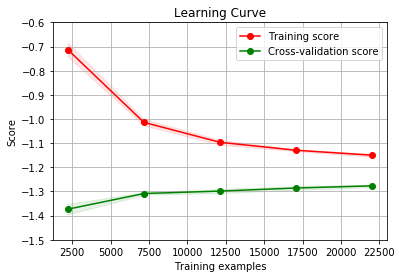

In [97]:
with_params = { # model 29
    'feats' : ['patient_nbr', 'admission_type_id','discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures','num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'metformin', 'repaglinide','nateglinide', 'chlorpropamide', 'glimepiride', 
               'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone','rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin','glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone','metformin-pioglitazone', 'change', 'diabetesMed', 
       'race_cat', 'gender_cat', 'payer_code_cat','medical_specialty_cat', 'diag_1_cat', 'diag_2_cat', 'diag_3_cat',
       'age_cat', 'weight_cat', 'max_glu_serum_cat', 'A1Cresult_cat','diag_nr', 'encounter_nr', 'intervention_nr', 'emerg_nr',
       'ambulatory_nr', 'diag_complication_cat', 'diag_ha_cat','diag_ihd_cat', 'diag_circul_cat', 'diag_obesity_cat',
       'diag_high_number_80_cat', 'diag_high_risk_80_cat','diag_risk_max', 'diag_risk_max_log', 'diag_risk_sum',
       'diag_risk_sum_log', 'total_diag_risk', 'total_diag_risk_log','expired_cat', 'discharge_risk', 'sum_discharge_risk',
       'sum_discharge_risk_log', 'sum_number_outpatient','sum_number_emergency', 'sum_number_inpatient',
       'sum_num_procedures', 'sum_num_lab_procedures','sum_time_in_hospital', 'drug_multi_nr', 'drug_multi_cat',
       'drug_none_cat', 'drug_insulin_cat', 'drug_change_cat','drug_up_cat', 'drug_down_cat', 'sum_time_in_hospital_log',
       'sum_num_lab_procedures_log', 'sum_num_procedures_log','sum_num_medications', 'sum_num_medications_log',
       'sum_number_outpatient_log', 'sum_number_emergency_log','sum_number_inpatient_log', 'sum_number_diagnoses',
       'sum_number_diagnoses_log', 'sum_intervention_nr','sum_intervention_nr_log', 'sum_emerg_nr', 'sum_emerg_nr_log',
       'sum_ambulatory_nr', 'sum_ambulatory_nr_log', 'sum_drug_multi_nr','sum_drug_multi_nr_log', 'total_diag_risk',
       'total_diag_risk_log', 'sum_diag_nr', 'sum_diag_nr_log'],
    'model' : xgb.XGBClassifier,
    'params': {'n_jobs': 8,
               'random_state': 2019,
               'objective': 'reg:squarederror',
               'max_depth': 5,
               'subsample': 0.95,
               'colsample_bylevel': 0.95,
               'colsample_bynode': 0.95, 
               'colsample_bytree': 0.95},
    'cv'    : None,
    'plot'  : True,
    'csv'   : 'submit_model29_clas_all.csv'    
}

%time result = run_model(**with_params)
print(result[:3])

### model wybrany do oceny - 1.20466 -> 1.25317 

In [98]:
with_params = {
    'feats_1' : xgbfir_best_reg,
    'model_1' : xgb.XGBRegressor,
    'params_1': {'n_jobs': 8,
               'objective': 'reg:squarederror',
               'max_depth': 5,
                'learning_rate': 0.19692940856713395, 
                 'random_state': 47, 
                 'subsample': 0.9816247081732863},
    
    'feats_2' : xgbfir_best_clas + ['model1_cat'],
    'model_2' : xgb.XGBClassifier,
    'params_2': {'n_jobs': 8,
               'max_depth': 5,              
               'n_estimators': 100,
               'objective': 'binary:logistic',
                'learning_rate': 0.19771209231383705, 
                 'random_state': 10, 
                 'subsample': 0.9975635280860219},
    
    'cv'    : None,
    'plot'  : None,
    'csv'   : 'last.csv',
    'cut'   : 40
}

for x in range(55, 56):
    with_params['cut'] = x
    result = run_two_models(**with_params)
    print(result[:3], x)

(('test', 3892, 29278), ('train', 5721, 27330), ('score', (1.106832244964624, 0.9424828295664276))) 55


### najlepszy model - 1.20466 -> 1.24067

In [100]:
with_params = { # model 27
    'feats' : ['patient_nbr', 'admission_type_id','discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures','num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'metformin', 'repaglinide','nateglinide', 'chlorpropamide', 'glimepiride', 
               'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone','rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin','glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone','metformin-pioglitazone', 'change', 'diabetesMed',
       'race_cat', 'gender_cat', 'payer_code_cat','medical_specialty_cat', 'diag_1_cat', 'diag_2_cat', 'diag_3_cat',
       'age_cat', 'weight_cat', 'max_glu_serum_cat', 'A1Cresult_cat','diag_nr', 'encounter_nr', 'intervention_nr', 'emerg_nr',
       'ambulatory_nr', 'diag_ha_cat', 'diag_ihd_cat', 'diag_circul_cat','diag_obesity_cat', 'diag_high_number_80_cat',
       'diag_high_risk_80_cat', 'drug_change_cat', 'drug_up_cat','drug_down_cat', 'drug_multi_nr', 'drug_multi_cat',
       'drug_none_cat', 'drug_insulin_cat', 'model1_cat', 'diag_risk_max','diag_risk_sum', 'total_diag_risk', 
               'total_diag_risk_log',
       'diag_risk_max_log', 'diag_risk_sum_log', 'sum_number_outpatient','sum_number_emergency', 'sum_number_inpatient',
       'sum_num_procedures', 'sum_num_lab_procedures','sum_time_in_hospital', 'sum_num_medications',
       'sum_number_diagnoses', 'sum_intervention_nr', 'sum_emerg_nr','sum_ambulatory_nr', 'sum_time_in_hospital_log',
       'sum_num_lab_procedures_log', 'sum_num_procedures_log','sum_num_medications_log', 'sum_number_outpatient_log',
       'sum_number_emergency_log', 'sum_number_inpatient_log','sum_number_diagnoses_log', 'sum_intervention_nr_log',
       'sum_emerg_nr_log', 'sum_ambulatory_nr_log', 'sum_drug_multi_nr','sum_drug_multi_nr_log', 'total_diag_risk',
       'total_diag_risk_log', 'diag_complication_cat', 'sum_diag_nr','sum_diag_nr_log'],
    'model' : xgb.XGBRegressor,
    'params': {'n_jobs': 8,
               'random_state': 2019,
               'objective': 'reg:squarederror',
               'max_depth': 5,
               'subsample': 0.95},
    'cv'    : None,
    'plot'  : None,
    'csv'   : 'submit_model27_reg_log_all.csv',
    'cut'   : 40
}
result = None
for x in range(49, 50):
    with_params['cut'] = x
    result = run_model(**with_params)
    print(result[:3], x)

(('test', 3977, 29193), ('train', 5721, 27330), ('score', 1.1839145965045461)) 49


### ile błędów w predykcji dla 30% i 70% - dla wyników '0' lub '100'

In [ ]:
total_number = 33170
fract = 0.3
part = int(total_number * fract)

for x in range(0, part-1):
    exp_train = np.array([0] * part)
    exp_test = np.array(([0] * (part-x)) + ([100] * x))
    result = rmsle(exp_train, exp_test)
    if result > 1.19215:
        print (x, result)
        break

# 664 1.1921577407154704 1.19215        
# 671 1.1984252297849942 1.19842
# 677 1.2037713911774424 1.20377
# 678 1.2046601114101099 1.20466
# 679 1.2055481764856852 1.20554
# 760 1.2754295637395079 1.27542
# 863 1.359111481082803 1.35904
# 870 1.3646123884270185 1.36461

In [ ]:
total_number = 33170
fract = 0.7
part = int(total_number * fract)

for x in range(0, part-1):
    exp_train = np.array([0] * part)
    exp_test = np.array(([0] * (part-x)) + ([100] * x))
    result = rmsle(exp_train, exp_test)
    if result > 1.37903:
        print (x, result)
        break

# 1630 1.2227990506636657 1.22279      
# 1647 1.2291590702706483 1.22915
# 1693 1.2462058044513455 1.24620
# 1710 1.2524469684473143 1.25244
# 1829 1.2952933725011357 1.29529
# 2074 1.3793220111367726 1.37903